# Models Comparison 
__Capstone Project - CRM Predictions__

First, we import libraries, arrays and list we are going to use for this section.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import time
import os
from IPython.display import Image

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')

In [2]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']
n_classes = len(class_labels)

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [3]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "conservative": X_train_outliers_conservative,
    "aggressive": X_train_outliers_aggressive,
    "lof": X_train_outliers_lof,
    "iforest": X_train_outliers_iforest
}

# Model Dictionnary

We log from our different model experimention, the best model chosen.

In [4]:
models = [
    {
        "model_name": "LogisticRegression",
        "model": LogisticRegression(C=0.5,
                                     multi_class='multinomial',
                                     penalty='l2',
                                     solver='saga',
                                     max_iter=1000,
                                     tol=1e-3),
        "model_filename": "LogisticRegression.csv"
    },
    {
        "model_name": "RandomForest",
        "model": RandomForestClassifier(n_estimators=300, 
                                         max_features=30,
                                         criterion='gini', 
                                         max_depth=10),
        "model_filename": "RandomForest.csv"
    },
    {
        "model_name": "KNeighbors",
        "model": KNeighborsClassifier(n_neighbors=10),
        "model_filename": "KNeighbors.csv"
    },
    {
        "model_name": "XGBClassifier",
        "model": xgb.XGBClassifier(objective='multi:softmax', 
                                    eval_metric='mlogloss',
                                    max_depth=4,
                                    n_estimators=300,
                                    learning_rate=0.2,
                                    colsample_bytree=0.8),
        "model_filename": "XGBClassifier.csv"
    },
    {
        "model_name": "MLPClassifier",
        "model": MLPClassifier(tol=1e-3,
                               hidden_layer_sizes=(100,),
                               activation='logistic',
                               solver='adam',
                               alpha=0.01,
                               learning_rate='constant',
                               max_iter=350),
        "model_filename": "MLPClassifier.csv"
    }
]

In [5]:
csv_files = [model_dict["model_filename"] for model_dict in models]

Here we apply method that has found common success we all our models
- We exclude outliers based on our most aggressive method, all outliers that are flagged __either__ by 3 zscores, LOF or iForest.
- We apply Robust Scaler to our features

In [6]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train = X_train[outlier_mask != 1]
y_train = y_train[outlier_mask != 1]

In [7]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Results

## Overall scores

We recalculate :
- Precision, recall and f1 weighted by model
- f1 weighted by model and by rfm label. We are looking to know if a model particularly perfoms well on one rfm label.

We first append all our results to a dictionnary before using dictionnary for plotting.

In [8]:
# Define the labels of interest and column names
labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

# Find column indices corresponding to OHE rfm_label columns
label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

# Fit the models, calculate the metrics for each label of interest and overall
results = []
for model_info in models:
    model = model_info["model"]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = []
    for i, label in enumerate(labels_of_interest):
        label_index = label_indices[i]
        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)
        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)

        metrics.append((precision, recall, f1))

    overall_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    overall_precision = round(overall_report['weighted avg']['precision'], 2)
    overall_recall = round(overall_report['weighted avg']['recall'], 2)
    overall_f1 = round(overall_report['weighted avg']['f1-score'], 2)

    results.append({
        "model_name": model_info["model_name"],
        "metrics": metrics,
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1_score": overall_f1
    })

We calculate overfitting by model using a cross validation scored on f1 weighted.

In [9]:
# Create F1 weighted scorer
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# Calculate overfitting metric for each model and add it to the results dictionary
for i, model_info in enumerate(models):
    model = model_info["model"]
    
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=f1_weighted_scorer, return_train_score=True)
    
    # Calculate overfitting metric
    overfitting = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Add overfitting metric to the corresponding result dictionary
    results[i]['overfitting'] = overfitting

In [10]:
results

[{'model_name': 'LogisticRegression',
  'metrics': [(0.44, 0.45, 0.42), (0.48, 0.51, 0.48), (0.54, 0.61, 0.56)],
  'overall_precision': 0.5,
  'overall_recall': 0.52,
  'overall_f1_score': 0.51,
  'overfitting': 0.001975452985559123},
 {'model_name': 'RandomForest',
  'metrics': [(0.51, 0.5, 0.47), (0.56, 0.56, 0.51), (0.64, 0.67, 0.63)],
  'overall_precision': 0.56,
  'overall_recall': 0.57,
  'overall_f1_score': 0.56,
  'overfitting': 0.0895112678441119},
 {'model_name': 'KNeighbors',
  'metrics': [(0.47, 0.47, 0.46), (0.52, 0.53, 0.52), (0.58, 0.61, 0.59)],
  'overall_precision': 0.54,
  'overall_recall': 0.54,
  'overall_f1_score': 0.53,
  'overfitting': 0.11222668980282557},
 {'model_name': 'XGBClassifier',
  'metrics': [(0.56, 0.56, 0.55), (0.61, 0.62, 0.59), (0.68, 0.71, 0.69)],
  'overall_precision': 0.62,
  'overall_recall': 0.63,
  'overall_f1_score': 0.62,
  'overfitting': 0.11803898328951179},
 {'model_name': 'MLPClassifier',
  'metrics': [(0.48, 0.48, 0.47), (0.53, 0.55, 0

We can now plot our results

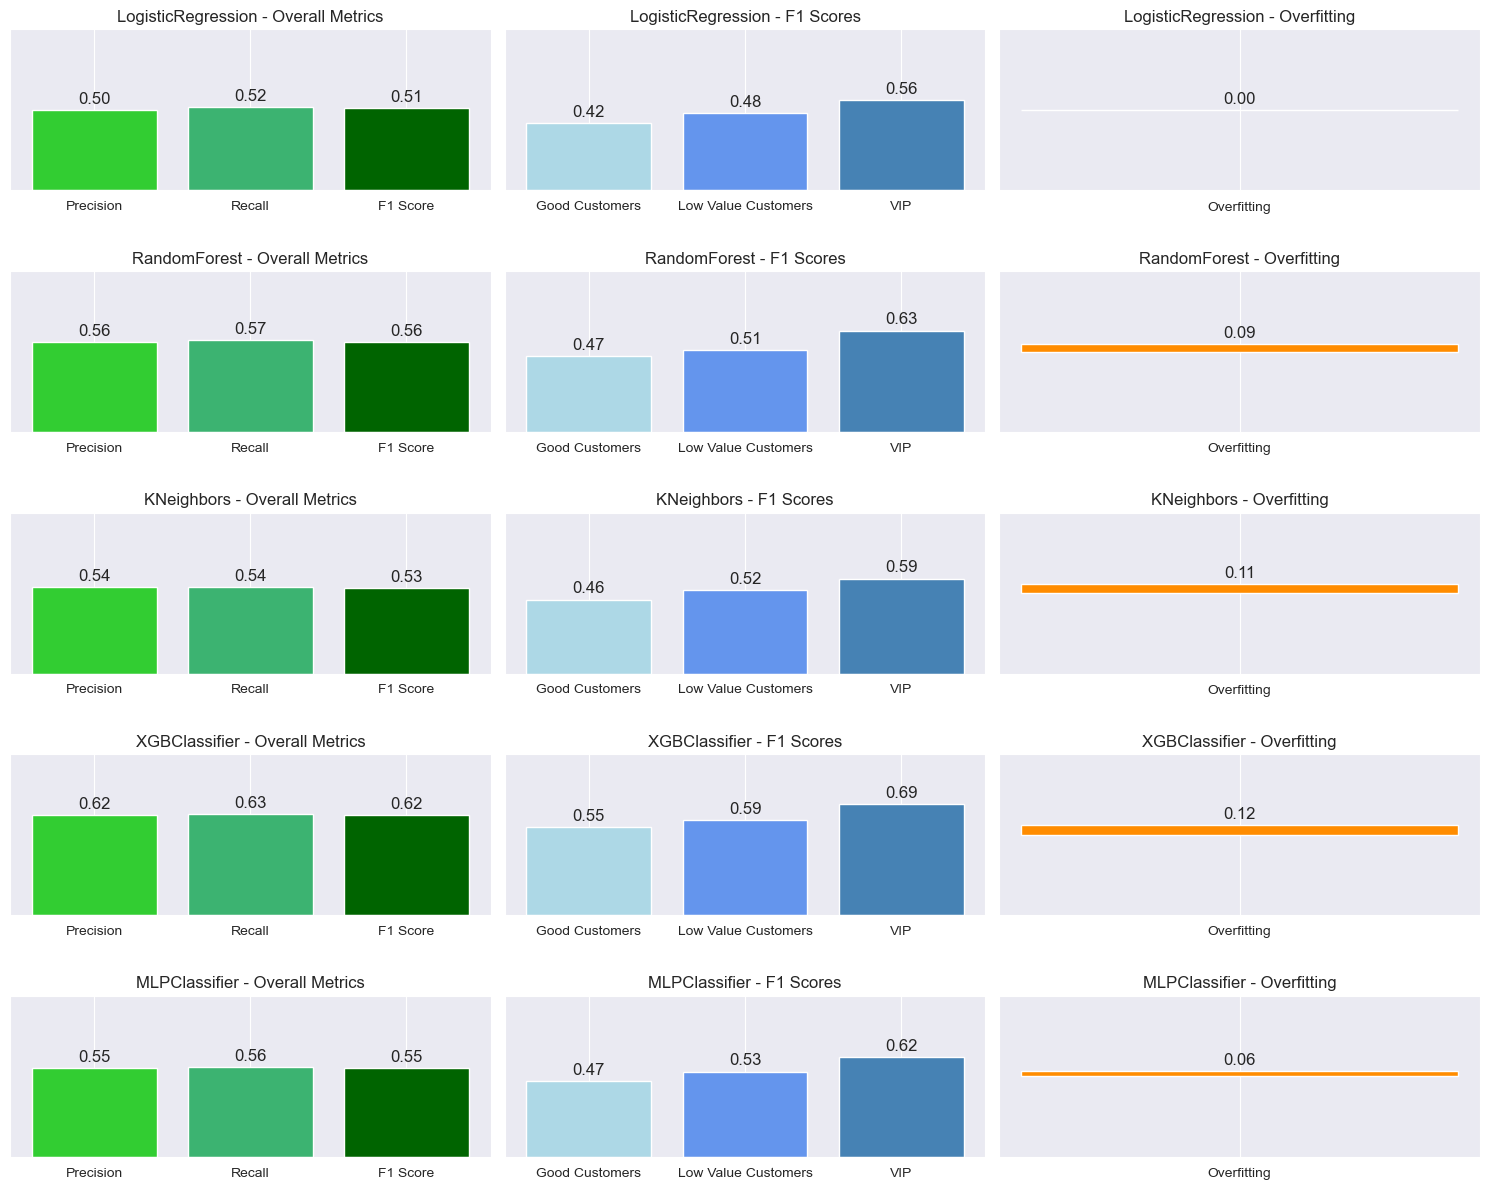

In [11]:
rfm_names = ['Good Customers', 'Low Value Customers', 'VIP']

fig, axs = plt.subplots(5, 3, figsize=(15, 12))

# Custom function to add labels on top of bars 
def autolabel(rects, ax, fontsize=12):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=fontsize)

for i, result in enumerate(results):
    model_name = result['model_name']
    overall_metrics = [result['overall_precision'], result['overall_recall'], result['overall_f1_score']]
    f1_scores = [m[-1] for m in result['metrics']]
    overfitting = result['overfitting']
    
    # Results overall
    rects1 = axs[i, 0].bar(
        ['Precision', 'Recall', 'F1 Score'],
        overall_metrics,
        color=['limegreen', 'mediumseagreen', 'darkgreen']
    )
    axs[i, 0].set_title(f'{model_name} - Overall Metrics')
    axs[i, 0].set_ylim(0, 1)
    axs[i, 0].set_yticks([])
    
    # Results by rfm label
    rects2 = axs[i, 1].bar(
        rfm_names,
        f1_scores,
        color=['lightblue', 'cornflowerblue', 'steelblue']
    )
    axs[i, 1].set_title(f'{model_name} - F1 Scores')
    axs[i, 1].set_ylim(0, 1)
    axs[i, 1].set_yticks([])
    
    # Overfitting
    rects3 = axs[i, 2].bar(
        ['Overfitting'],
        [overfitting],
        color=['darkorange']
    )
    axs[i, 2].set_title(f'{model_name} - Overfitting')
    axs[i, 2].set_ylim(-1, 1)
    axs[i, 2].set_yticks([])
    
    # Adding labels
    autolabel(rects1, axs[i, 0])
    autolabel(rects2, axs[i, 1])
    autolabel(rects3, axs[i, 2])

plt.tight_layout(h_pad=1.0, w_pad=1.0)
plt.subplots_adjust(hspace=0.5)
plt.savefig("ModelsResults.png")
plt.show()

The results for all models reveal the following:

- Precision and recall: Generally quite similar, with recall slightly outperforming precision in some models.
- F1-weighted scores across RFM labels: 
    - All our models perform better on VIP than Low Value Customers and better on Low Value Customers than Good Customers.
    - XGBoost, in particular, performs well on VIP classification.

## Comparative Confusion matrix

Now we want to compare confusion matrix for each model.

In [12]:
# Create a mapping of segment labels to integer values
class_map = {
    'SD': 0,
    'SB': 1,
    'LVC': 2,
    'GC': 3,
    'VIP': 4
}

class_names = list(class_map.keys())
class_labels = list(class_map.values())

In [13]:
# Fit models and store their confusion matrices
confusion_matrices = []
for model_info in models:
    model = model_info["model"]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    confusion_matrices.append(cm)

As we have 5 models, we draw a 5 by 5 figure where the diagonal is the confusion matrix for the model and the other suplots are differences between confusion matrices (difference in recall as we calculate our confusion matrix with normalize='true').

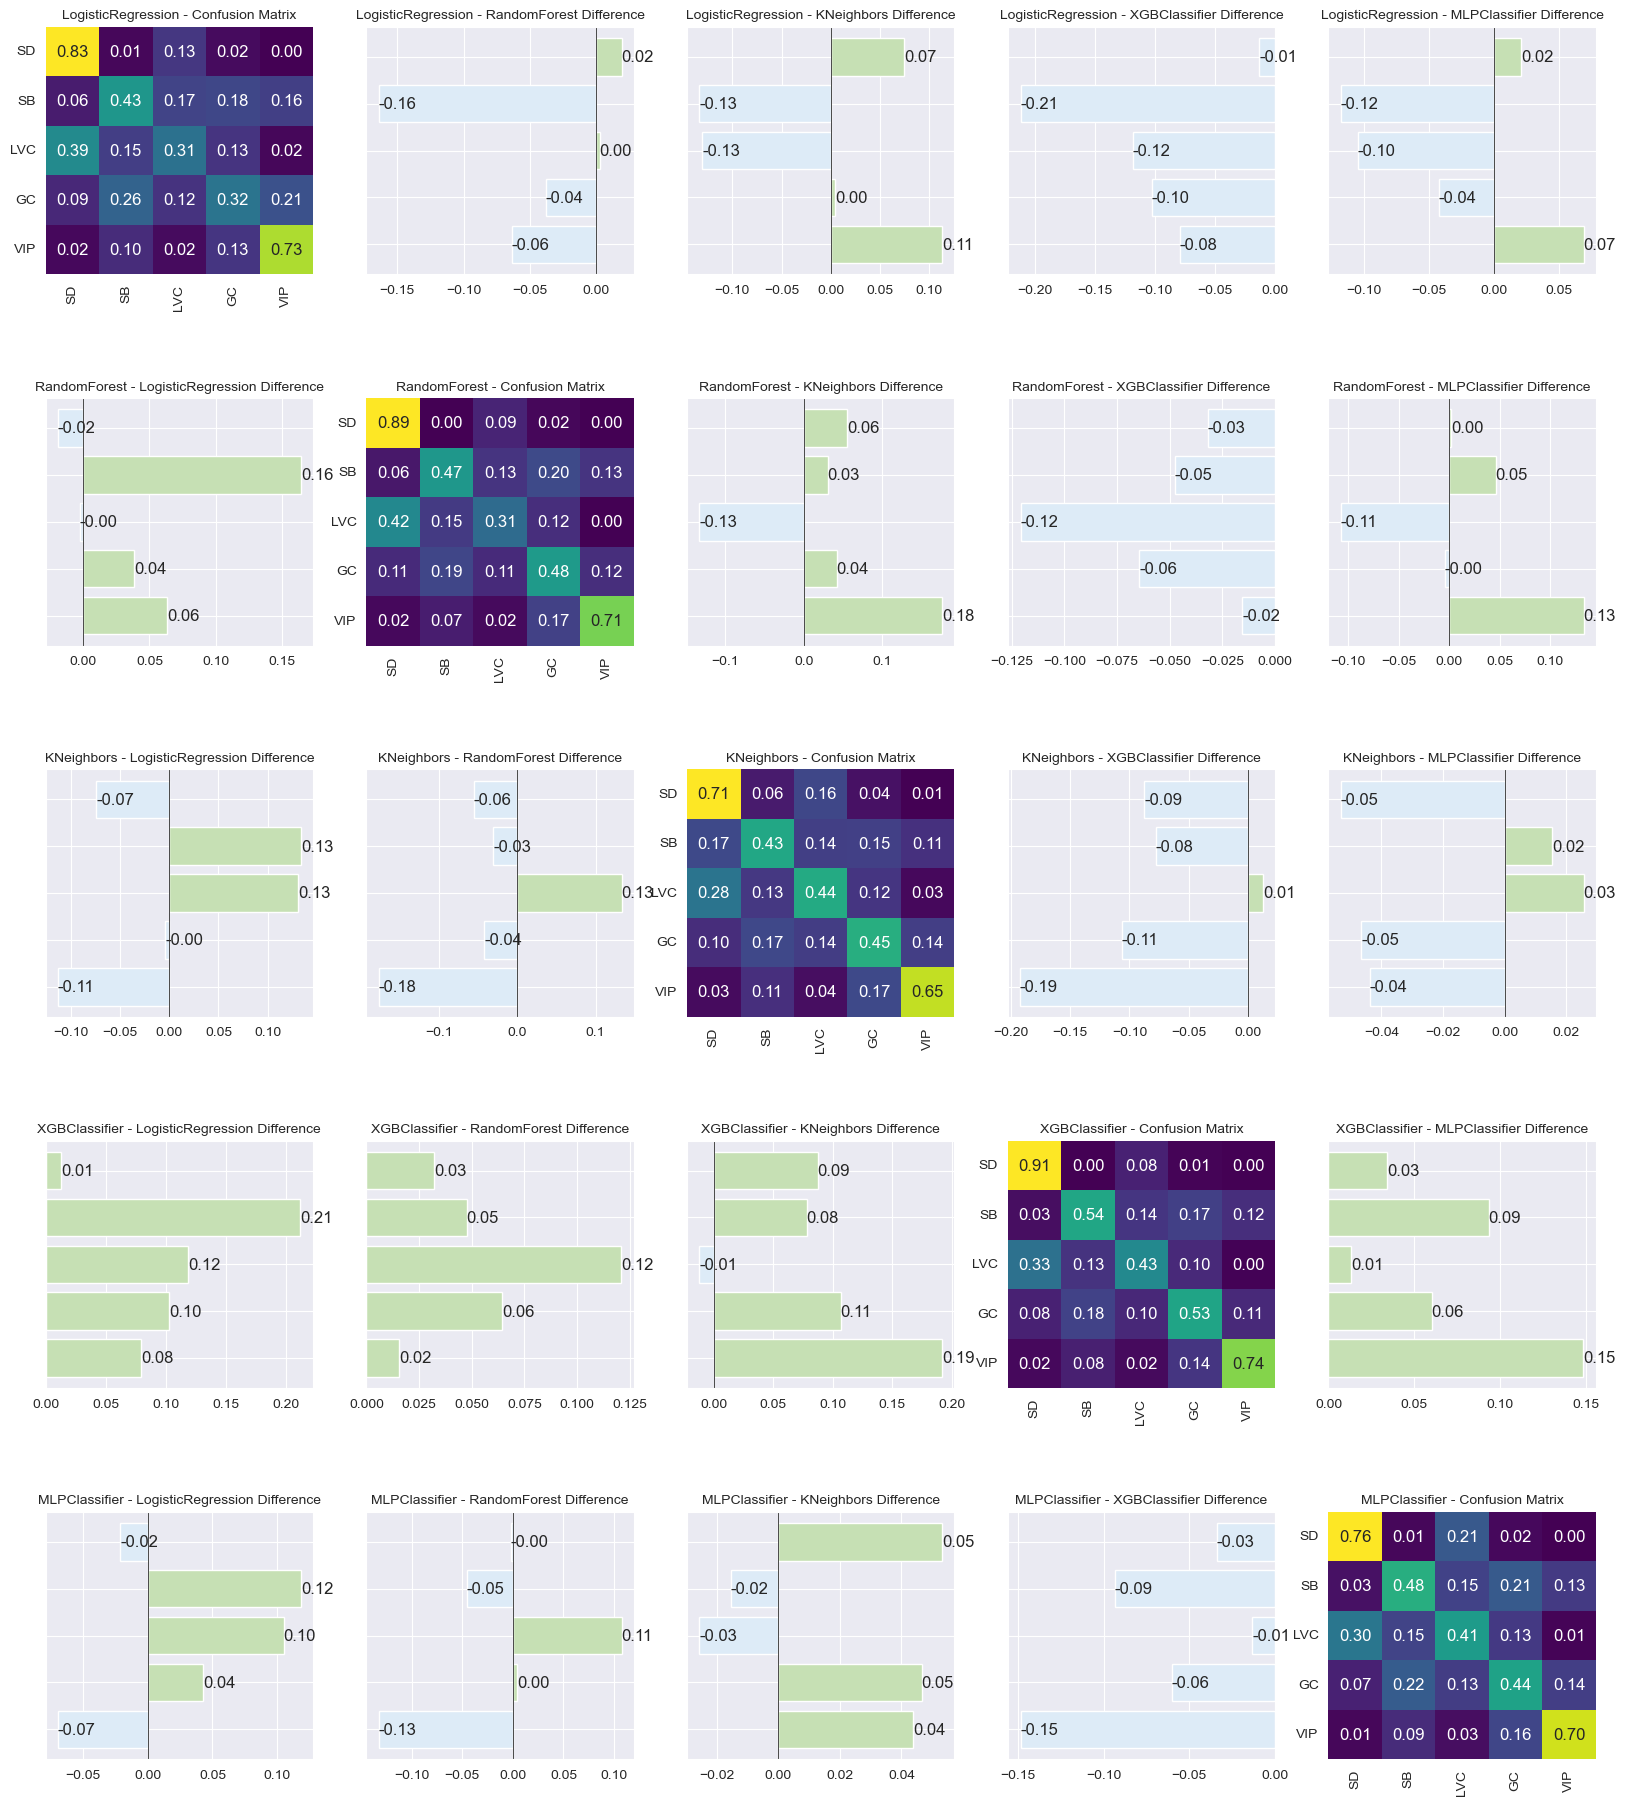

In [14]:
n_models = len(models)
fig, axes = plt.subplots(nrows=n_models, ncols=n_models, figsize=(n_models * 4, n_models * 4.5))

for i, model_info_i in enumerate(models):
    for j in range(n_models):
        
        # Case for diagonal, we plot a confusion matrix
        if i == j:
            sns.heatmap(
                confusion_matrices[i],
                annot=True,
                cmap='viridis',
                cbar=False,
                fmt='.2f',
                ax=axes[i, j],
                annot_kws={"size": 12}
            )
            # Formatting title and axis labels
            axes[i, j].set_title(f"{model_info_i['model_name']} - Confusion Matrix", fontsize=10)
            axes[i, j].set_xticklabels(class_names, rotation=90, fontsize=10)
            axes[i, j].set_yticklabels(class_names, rotation=0, fontsize=10)

        else:
            # Case where we want to have the difference of confusion matrices 
            # as an horizontal bar chart
            tp_diff = confusion_matrices[i].diagonal() - confusion_matrices[j].diagonal()
            tp_diff_colors = ['#C6E0B4' if x > 0 else '#DDEBF7' for x in tp_diff]
            axes[i, j].barh(class_names, tp_diff, color=tp_diff_colors)
            axes[i, j].set_title(f"{models[i]['model_name']} - {models[j]['model_name']} Difference", fontsize=10)

            # Center y-axis at 0
            axes[i, j].axvline(0, color='black', linewidth=0.5)

            # Remove y-axis labels
            axes[i, j].set_yticklabels([])

            for index, value in enumerate(tp_diff):
                # Add data labels
                va = 'center'
                axes[i, j].text(value, index, f"{value:.2f}", fontsize=12, va=va)

plt.subplots_adjust(hspace=0.5)
plt.savefig("ConfusionMatrix.png")
plt.show()

XGBoost clearly outperforms other models in our case, we will at the very end display classification reports for XGBoost and compare it to baseline.

## Random Samples

We pick out at random samples and we display how many of them are:
- Correctly classified by all models
- Incorrectly classified by all models
- A case where Models disagree

In [15]:
# Train all models
for model in models:
    model['model'].fit(X_train, y_train)

# Randomly select samples from test dataset
random_indices = np.random.choice(X_test.shape[0], 100, replace=False)
X_test_sample = X_test[random_indices, :]
y_test_sample = y_test[random_indices]

# Obtain predictions from all models for the selected samples
predictions = []
for model in models:
    preds = model['model'].predict(X_test_sample)
    predictions.append(preds)

# Compare predictions to true labels and create a binary matrix (1 for correct, 0 for incorrect)
binary_results = np.array([preds == y_test_sample for preds in predictions]).astype(int)

# Identify indices for samples that are correct for all models, incorrect for all models, and the rest
all_correct_indices = np.where(np.all(binary_results, axis=0))[0]
all_incorrect_indices = np.where(np.all(binary_results == 0, axis=0))[0]
remaining_indices = np.setdiff1d(np.arange(100), np.union1d(all_correct_indices, all_incorrect_indices))

# Order samples: all correct, all incorrect, and the rest
ordered_indices = np.concatenate((all_correct_indices, all_incorrect_indices, remaining_indices))

# Aggregate binary results in a DataFrame with the ordered columns
binary_results_df = pd.DataFrame(
    binary_results[:, ordered_indices],
    index=[model['model_name'] for model in models],
    columns=[f'Sample {i+1}' for i in ordered_indices]
)

# Calculate percentages of all agree, all disagree, and can't agree
total_samples = binary_results_df.shape[1]
all_agree_percentage = len(all_correct_indices) / total_samples * 100
all_disagree_percentage = len(all_incorrect_indices) / total_samples * 100
cant_agree_percentage = len(remaining_indices) / total_samples * 100

# Print the results
print(f"Percentage of times all models agree: {all_agree_percentage:.2f}%")
print(f"Percentage of times all models disagree: {all_disagree_percentage:.2f}%")
print(f"Percentage of times models can't agree: {cant_agree_percentage:.2f}%")

Percentage of times all models agree: 33.00%
Percentage of times all models disagree: 12.00%
Percentage of times models can't agree: 55.00%


It is stricking to see how much models don't agree. We now plot predictions in a horizontal image with two colors, to make it more visual.

Blue is when model is correct.

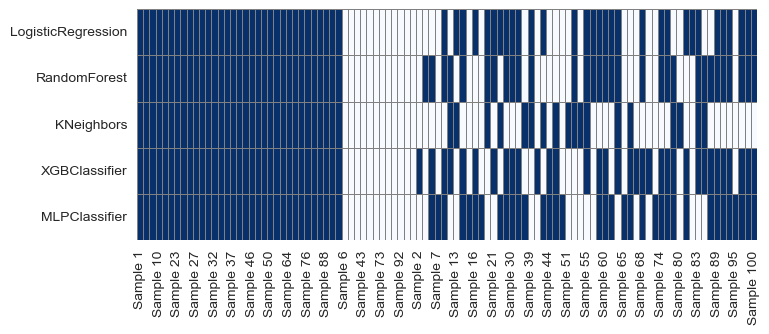

In [16]:
plt.figure(figsize=(8, 3))
sns.heatmap(
    binary_results_df,
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="gray"
)

plt.yticks(rotation=0)
plt.show()

# Permutation importance

## By Model

We use [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html) that shuffles values in a feature and see how score evolves to assess importance of features. This note from documentation is important and we will use this method with this in mind, as a way to check what features are important to what model, as another post modeling analysis.

>  Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

We store features as a csv in a custom folder to reload them afterwards in our post modeling notebook. 

One of the goal of this process is to be able to study top features in average and further study differences between correctly and incorrectly classified samples.

Running permutation importance for LogisticRegression
Time taken for permutation importance calculation: 4 seconds


<Figure size 500x1500 with 0 Axes>

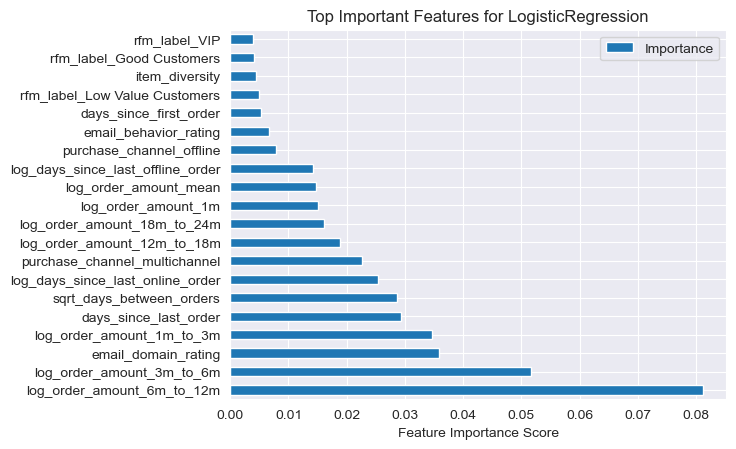

Running permutation importance for RandomForest
Time taken for permutation importance calculation: 228 seconds


<Figure size 500x1500 with 0 Axes>

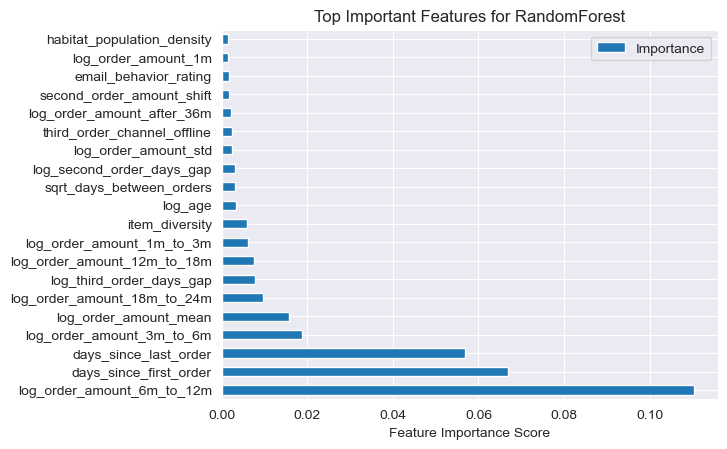

Running permutation importance for KNeighbors
Time taken for permutation importance calculation: 6877 seconds


<Figure size 500x1500 with 0 Axes>

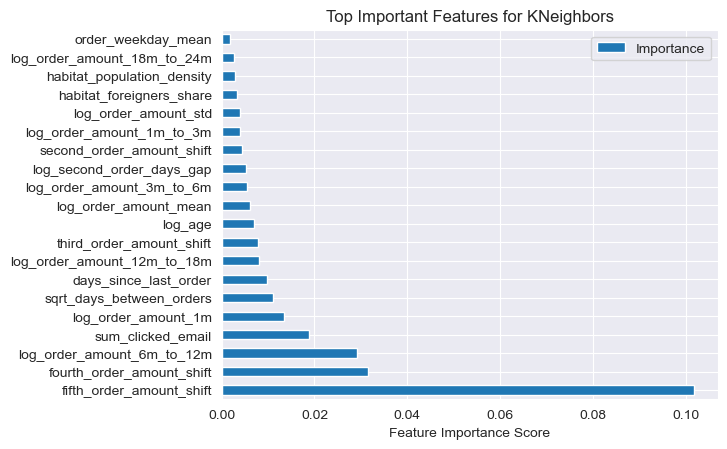

Running permutation importance for XGBClassifier
Time taken for permutation importance calculation: 29 seconds


<Figure size 500x1500 with 0 Axes>

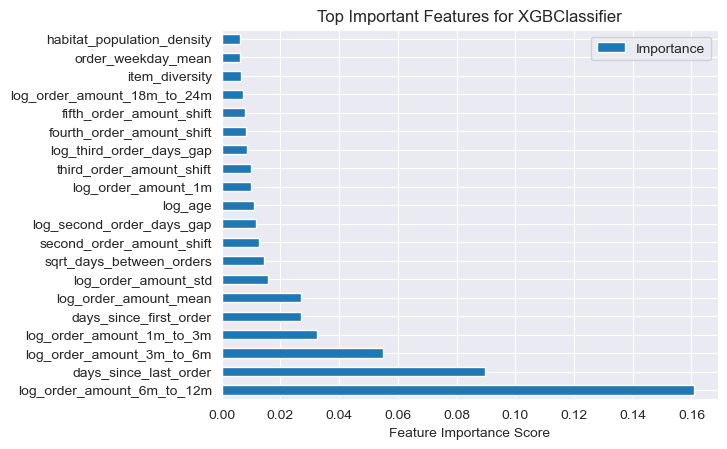

Running permutation importance for MLPClassifier
Time taken for permutation importance calculation: 14 seconds


<Figure size 500x1500 with 0 Axes>

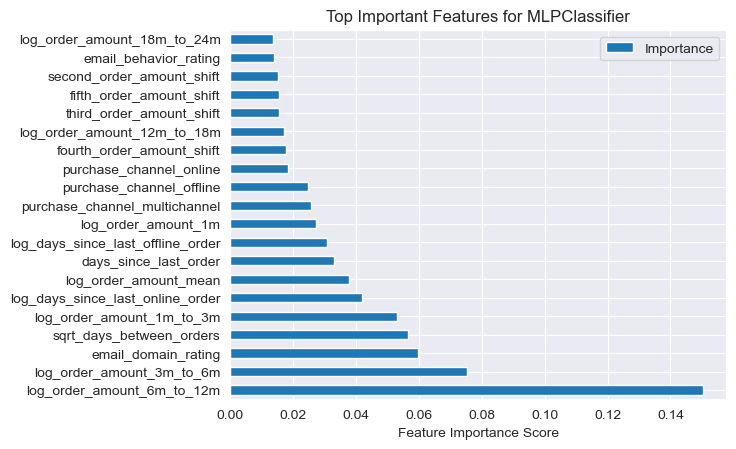

In [17]:
for model_dict in models:
    model_name = model_dict["model_name"]
    model = model_dict["model"]
    model_filename = model_dict["model_filename"]

    print(f"Running permutation importance for {model_name}")

    # Fit the model
    model.fit(X_train, y_train)

    # Start timer
    start_time = time.time()

    weighted_f1_scorer = make_scorer(f1_score, average='weighted')

    # Compute permutation importance on test dataset
    result = permutation_importance(
        model,
        X_test,
        y_test,
        scoring=weighted_f1_scorer,
        n_repeats=2,
        random_state=0
    )

    # End timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the elapsed time
    print("Time taken for permutation importance calculation: {:.0f} seconds".format(elapsed_time))

    # Store to a dataframe
    importances_df = pd.DataFrame(result.importances_mean, index=range(len(result.importances_mean)), columns=['Importance'])

    # Use columns names as index
    importances_df = importances_df.set_index(pd.Index(columns[:-1]))

    # Save features as a csv in a custom folder to reload them afterwards in our post modeling notebook
    file_path = os.path.join('features', model_filename)
    importances_df.to_csv(file_path)

    # Sort by importance
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    # Plot top features
    plt.figure(figsize=(5, 15))
    importances_df[:20].plot.barh()
    plt.xlabel('Feature Importance Score')
    plt.title(f'Top Important Features for {model_name}')
    plt.show()

## Combining features importance csv

Here, we compare feature importances accross models to see if we have some learnings that are common accross all models

In [18]:
def read_csv_files(file_list, folder='features'):
    '''
    Reads CSV files containing feature importances for different models
    and returns a dictionary with model names as keys and DataFrames as values.
    '''
    data = {}
    for file in file_list:
        model_name = file.split('.')[0]
        data[model_name] = pd.read_csv(os.path.join(folder, file), index_col=0)
    return data

In [19]:
model_data = read_csv_files(csv_files)

In [20]:
def combine_dataframes(data):
    '''
    Combines DataFrames with feature importances from multiple models into
    a single DataFrame.
    '''
    combined_df = None
    for model_name, df in data.items():
        if combined_df is None:
            combined_df = df[['Importance']].rename(columns={'Importance': model_name})
        else:
            combined_df = combined_df.join(df[['Importance']].rename(columns={'Importance': model_name}))
    return combined_df

In [21]:
combined_df = combine_dataframes(model_data)

## Top features

In [22]:
def plot_top_features(df, top_n=15):
    '''
    Plot top features from models, default 20 features
    Uses mean value accross models to select
    '''
    # Calculate mean importance for each feature across models
    df['Mean'] = df.mean(axis=1)
    
    # Sort features based on mean importance and select top
    top_features = df.sort_values('Mean', ascending=False).head(top_n)
    
    # Plot the horizontal bar chart
    top_features.plot(kind='barh', figsize=(9, 6))
    plt.xlabel('Feature Importance')
    plt.title('Top {} Features by Importance across Models'.format(top_n))
    plt.gca().invert_yaxis()
    plt.legend(loc='lower right')
    plt.savefig("TopFeatures.png")
    plt.show()

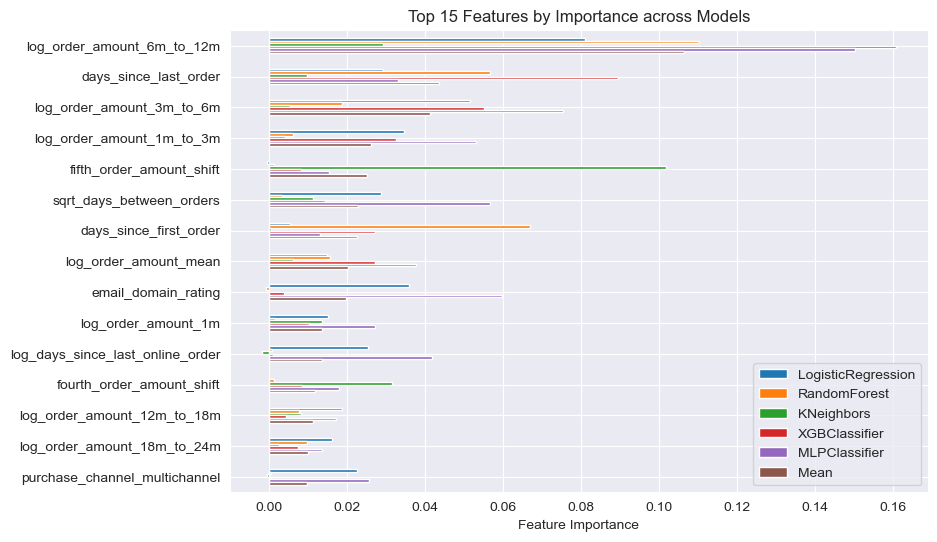

In [23]:
plot_top_features(combined_df)

### Key Takeaways

* As anticipated, `order_amounts` hold significance, but the focus lies on the 6-12 month range (`order_amount_6m_to_12m`) instead of recent orders (`order_amount_1m`), possibly due to increased variance.
* Surprisingly, the `average_days_between_orders` and `email_domain_rating` features are also crucial in the models.
* The `days_since_last_order` feature is more influential than `days_since_first_order`, suggesting that recency of purchase activity matters more than the overall time a customer has been in the database.
* The importance of being a `multichannel_customer` and the `days_since_last_online_order` demonstrate that the purchasing channel plays a part in making predictions.

## Bottom features

In [24]:
def plot_bottom_features(df, bottom_n=15):
    '''
    Plot bottom features from models, default 30 features
    Uses mean value accross models to select
    '''
    # Calculate mean importance for each feature across models
    df['Mean'] = df.mean(axis=1)
    
    # Sort features based on mean importance and select bottom features
    bottom_features = df.sort_values('Mean', ascending=True).head(bottom_n)
    
    # Plot horizontal bar chart
    bottom_features.plot(kind='barh', figsize=(9, 6))
    plt.xlabel('Feature Importance')
    plt.title('Bottom {} Features by Importance across Models'.format(bottom_n))
    plt.legend(loc='upper right')
    plt.savefig("Bottom Features.png")
    plt.show()

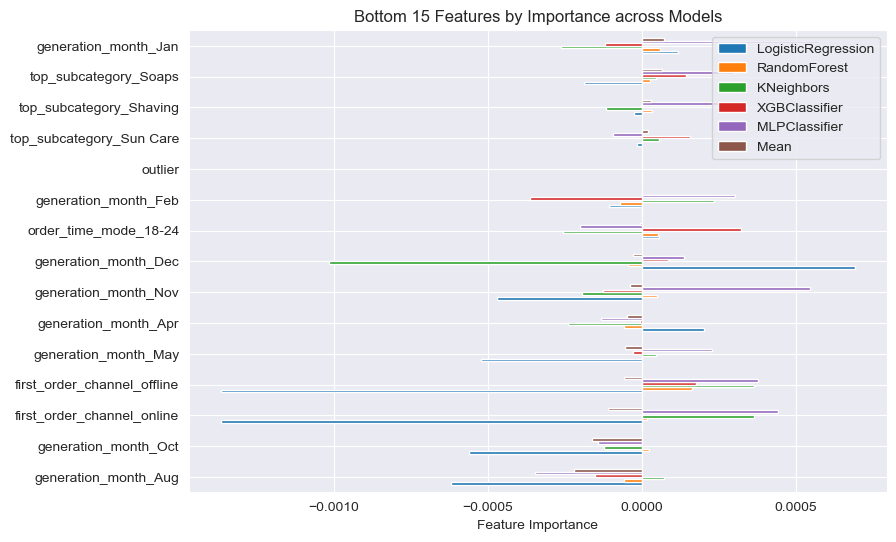

In [25]:
plot_bottom_features(combined_df)

### Key Takeaways

* `generation_month`, which represents the month the database was generated, is among the least significant features. This might indicate that the one-year-ahead prediction window is large enough to counteract any seasonal effects.
* The first order's purchasing channel (online or offline) seems irrelevant, while the `multichannel_customer` feature is crucial. This suggests that, to improve prediction accuracy, it is more effective to focus on driving customers to both online and offline channels, rather than considering the first purchase channel.
* The `top_subcategory_purchased` feature holds minimal importance, possibly because the high prevalence of skincare purchases causes top subcategories like Soaps or Face Cleansing to appear as outliers, which the model disregards during prediction.

# Error Analysis

We analyze misclassified instances for each model to identify patterns in the data that might explain the misclassification.

## Mean values

In [26]:
# Extract top features
top_features = combined_df.sort_values('Mean', ascending=False).index[:15]

# Prepare a dataframe to store results that are going to be plotted
results_df = pd.DataFrame(columns=['Model', 'Feature', 'Correct', 'Incorrect'])

# Analyze differences between correctly and incorrectly classified samples for each model
for model_dict in models:
    model_name = model_dict["model_name"]
    model = model_dict["model"]

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Boolean masking for correctly and incorrectly samples
    correct = (y_test == y_pred)
    incorrect = (y_test != y_pred)

    for feature in top_features:
        
        feature_index = list(columns).index(feature)
        
        # Calculate mean of each feature for correctly and incorrectly classified samples
        correct_mean = X_test[correct, feature_index].mean()
        incorrect_mean = X_test[incorrect, feature_index].mean()

        # Append the results to the results_df
        results_df = results_df.append({
            'Model': model_name,
            'Feature': feature,
            'Correct': correct_mean,
            'Incorrect': incorrect_mean
        }, ignore_index=True)
        
# Pivot results_df to plot more easily 
pivoted_results = results_df.pivot_table(index=['Model', 'Feature'])

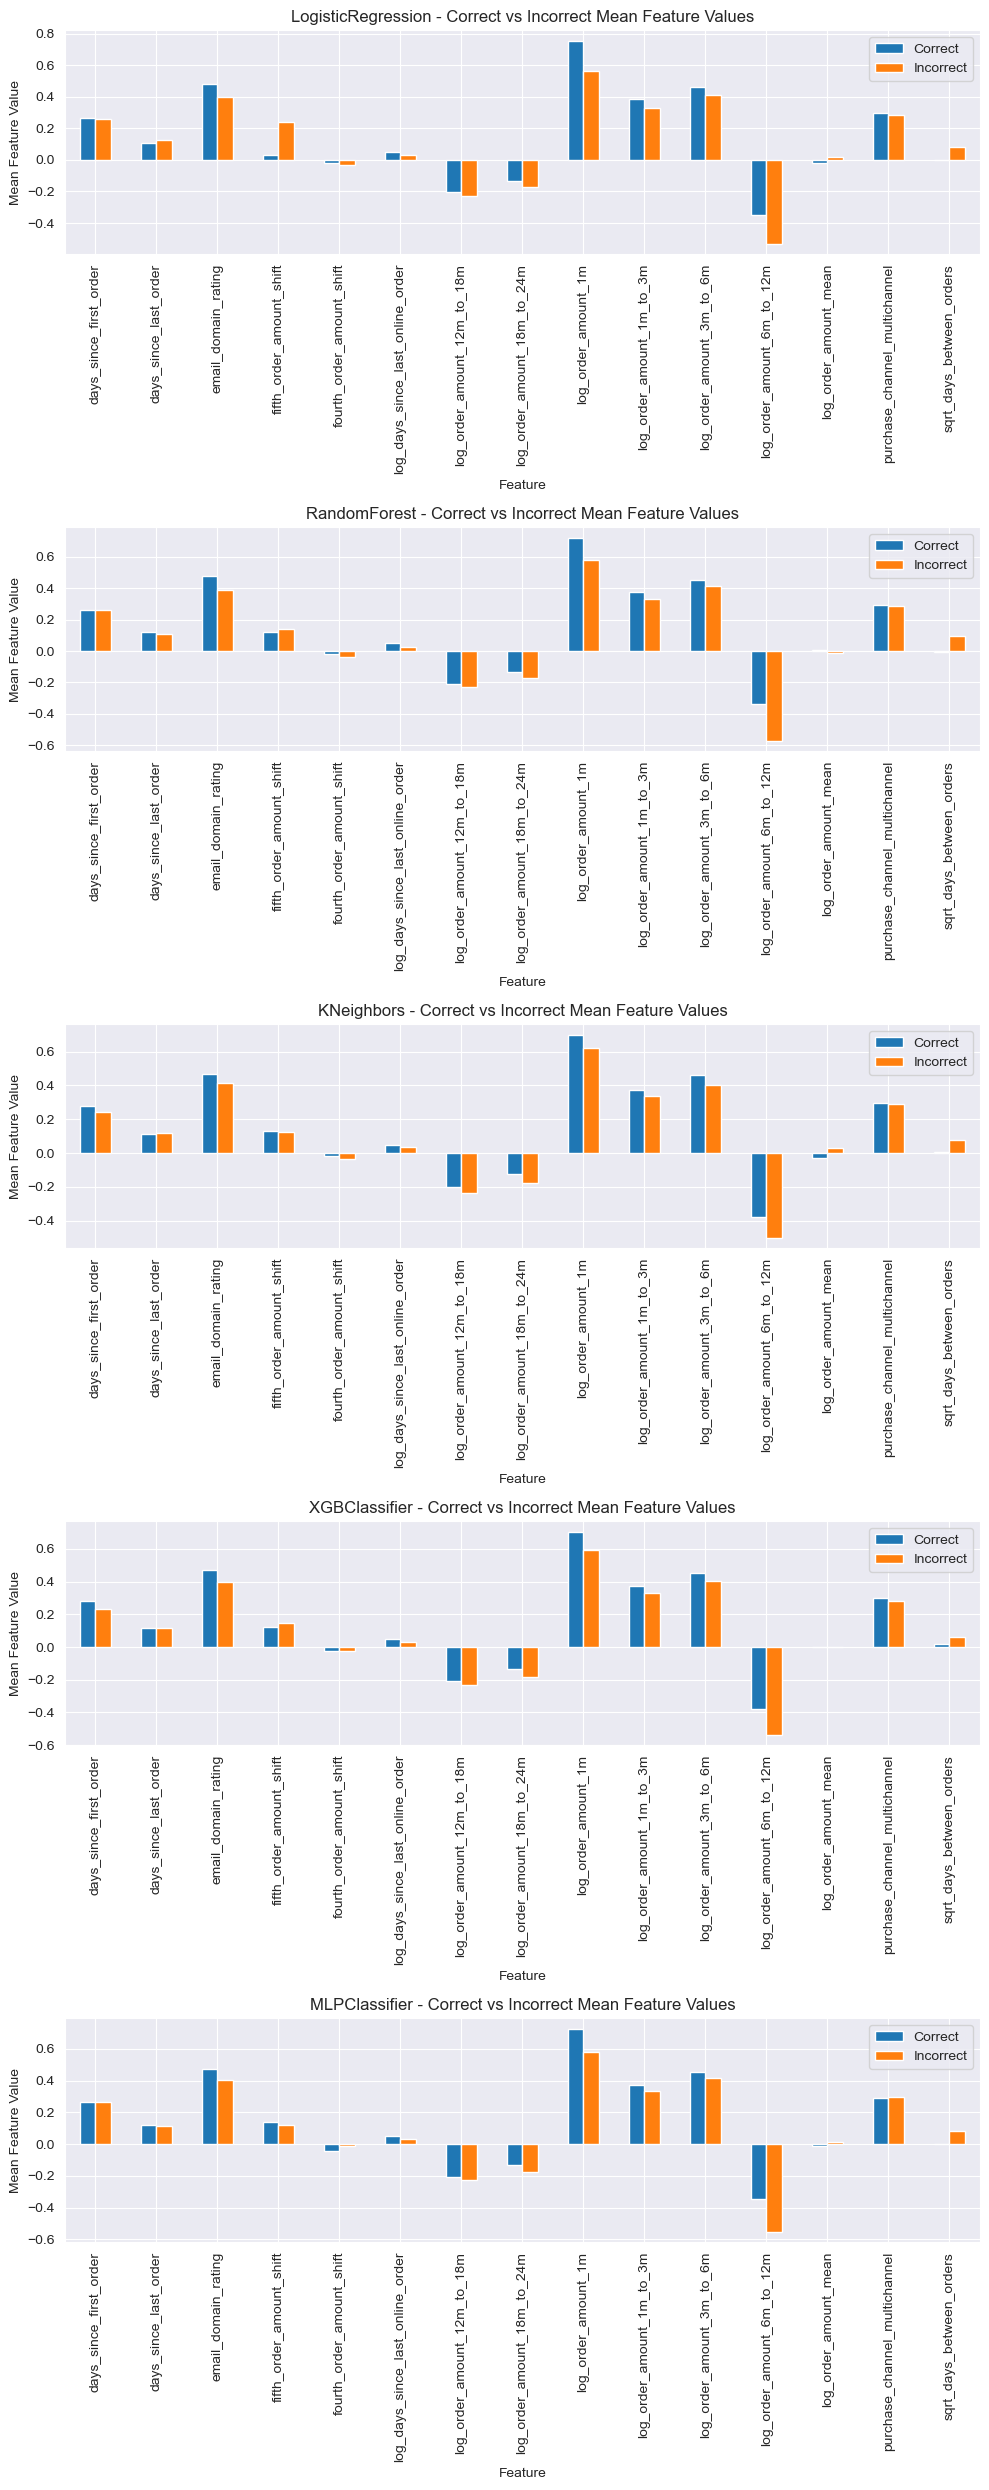

In [27]:
fig, axes = plt.subplots(len(models), figsize=(10, 5 * len(models)))

for model_dict, ax in zip(models, np.atleast_1d(axes)):
    model_name = model_dict["model_name"]
    data = pivoted_results.loc[model_name]
    data.plot(kind='bar', ax=ax)
    ax.set_title(f"{model_name} - Correct vs Incorrect Mean Feature Values")
    ax.set_ylabel("Mean Feature Value")
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Key Takeaways

After analyzing the mean values for the top features between correctly and incorrectly classified samples, no clear pattern has emerged. In some cases, the mean values are higher for one group, while in other cases, they are lower. However, none of these differences are particularly striking.

To gain a better understanding of these results, a more detailed analysis that takes the target label into account is necessary.

## Correlations

We first sort our top features alphabetically and we look at correlations between top features, distinguishing between correctly and incorrectly classified samples.

In [28]:
# Extract the top 10 features
top_features = combined_df.sort_values('Mean', ascending=False).index[:15]
top_features = sorted(top_features)

# Obtain predictions for the test dataset
correctly_classified = []
incorrectly_classified = []

for model_dict in models:
    model = model_dict["model"]

    # Fit model
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    correct_indices = np.where(preds == y_test)[0]
    incorrect_indices = np.where(preds != y_test)[0]
    
    correctly_classified.append(set(correct_indices))
    incorrectly_classified.append(set(incorrect_indices))

# Find intersection of correctly classified points and union of incorrectly classified points
common_correct = set.intersection(*correctly_classified)
common_incorrect = set.intersection(*incorrectly_classified)

df_test = pd.DataFrame(X_test, columns=columns[:-1])

df_test_top_features = df_test[top_features].copy()  # Create a new DataFrame using copy()
df_test_top_features['true_label'] = y_test

df_correct = df_test_top_features.loc[list(common_correct)]
df_incorrect = df_test_top_features.loc[list(common_incorrect)]

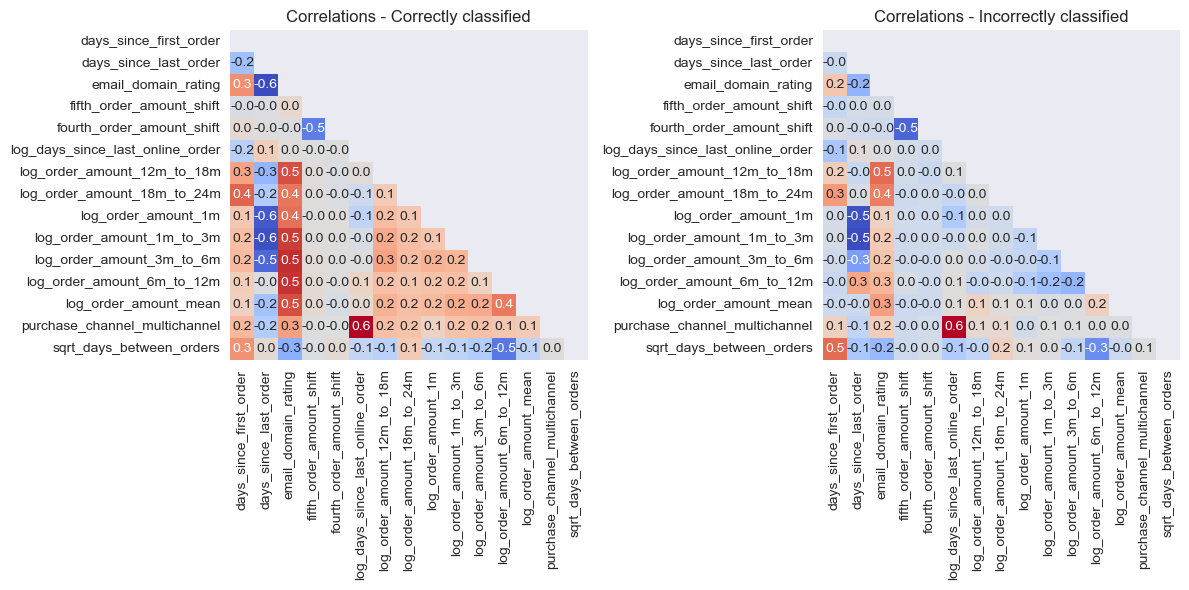

In [29]:
plt.figure(figsize=(12, 6))

# source https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
def lower_triangle_mask(matrix):
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    return mask

# Correctly classified
plt.subplot(1, 2, 1)
sns.heatmap(df_correct[top_features].corr(), annot=True, fmt='.1f', cmap='coolwarm', cbar=False, mask=lower_triangle_mask(df_correct[top_features].corr()))
plt.title('Correlations - Correctly classified')

# Incorrectly classified
plt.subplot(1, 2, 2)
sns.heatmap(df_incorrect[top_features].corr(), annot=True, fmt='.1f', cmap='coolwarm', cbar=False, mask=lower_triangle_mask(df_incorrect[top_features].corr()))
plt.title('Correlations - Incorrectly classified')

plt.tight_layout()
plt.savefig("CorrectIncorrect_CorrelationsTopFeatures.png")
plt.show()

### Key Takeaways

Based on the correlation analysis between top features in correctly and incorrectly classified samples, we can draw the following conclusions:

1. The selected top features are more informative and discriminative for correctly classified samples as they exhibit higher correlations (both positive and negative) compared to incorrectly classified samples.
2. The `log_order_amount_1m` feature shows weaker correlations with other order amounts in incorrectly classified samples, which suggests that it might not be as significant or informative for their classification.
3. The `email domain rating` feature demonstrates a strong correlation (around 0.45) with all `log_order_amount` features in correctly classified samples but only weak correlations in incorrectly classified samples. This indicates that the `email domain rating` might play a crucial role in the correct classification of samples.

## Distribution

As told in Mean values part, we need to further investigate distribution of correctly versus incorrectly classified samples by target label.

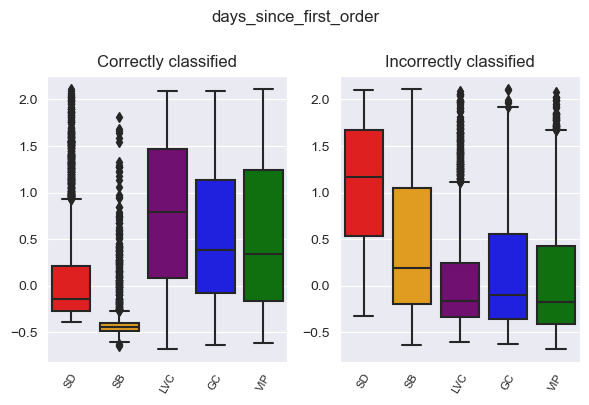

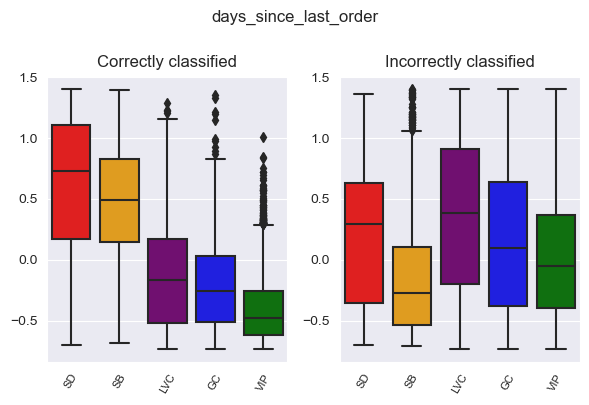

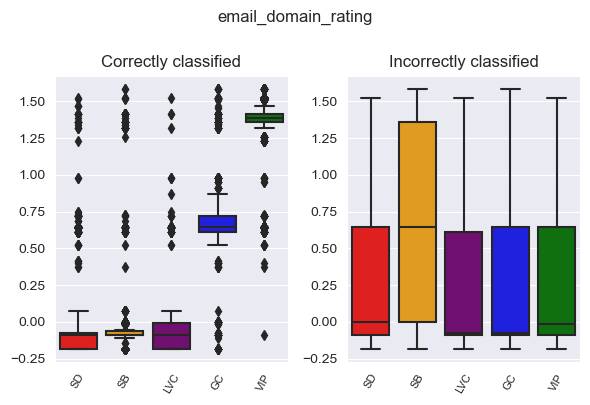

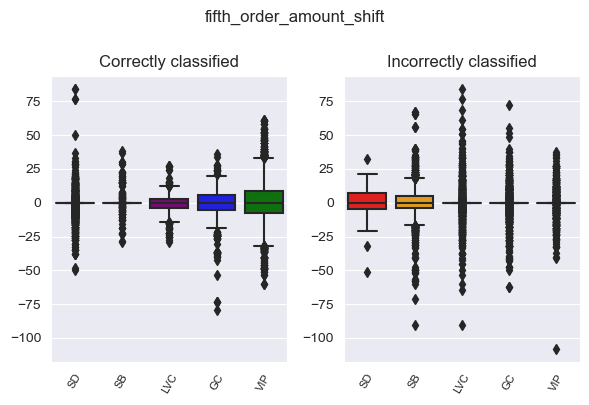

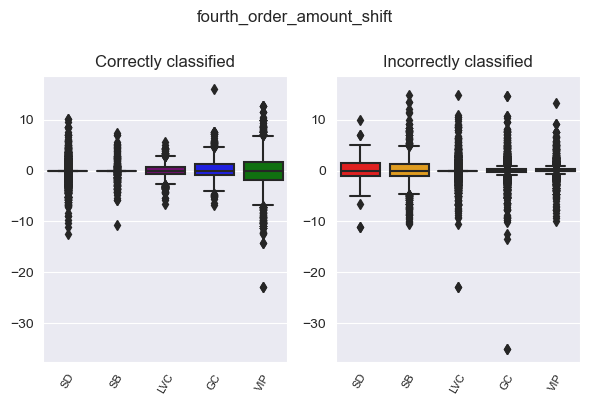

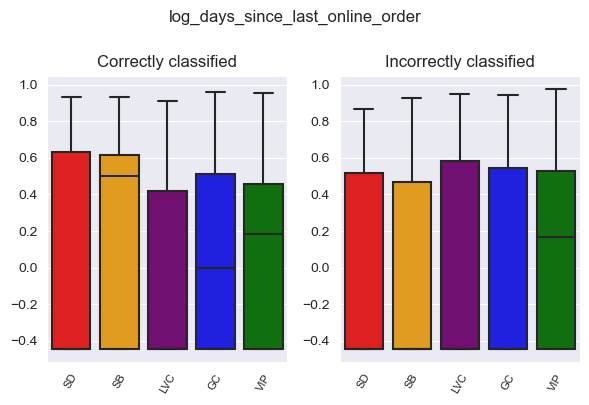

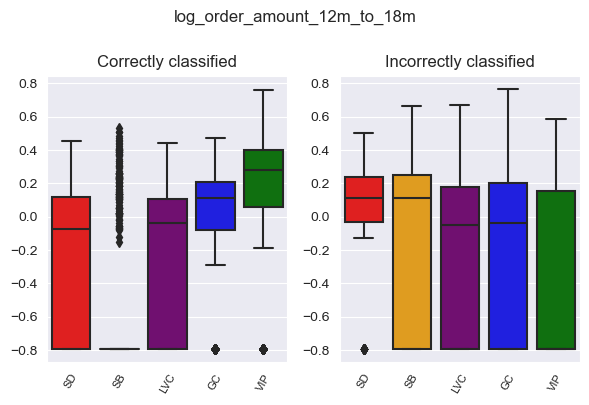

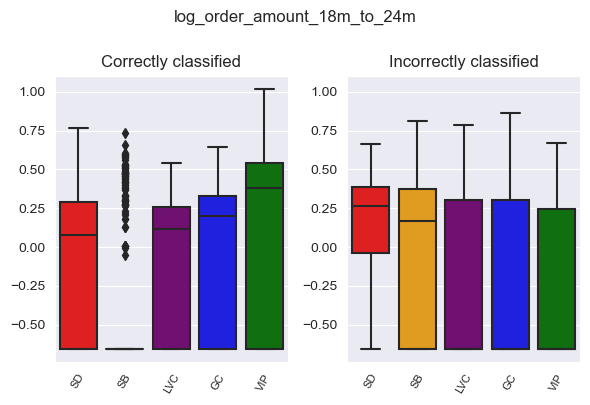

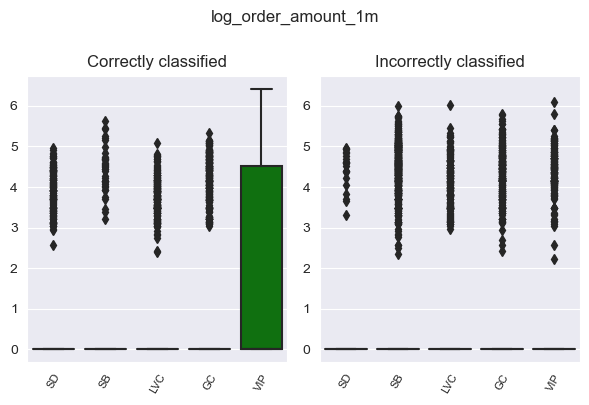

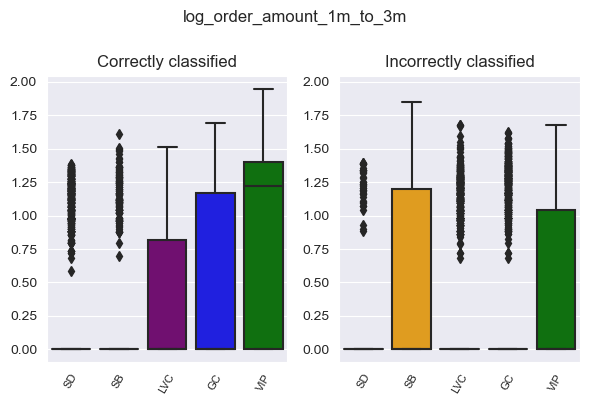

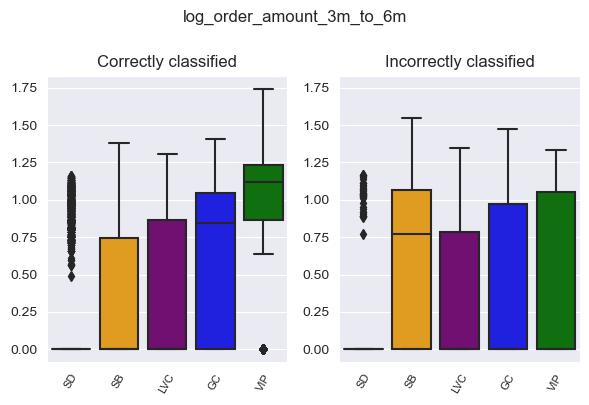

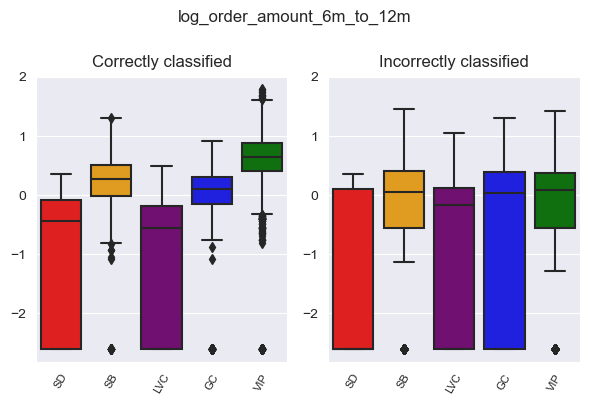

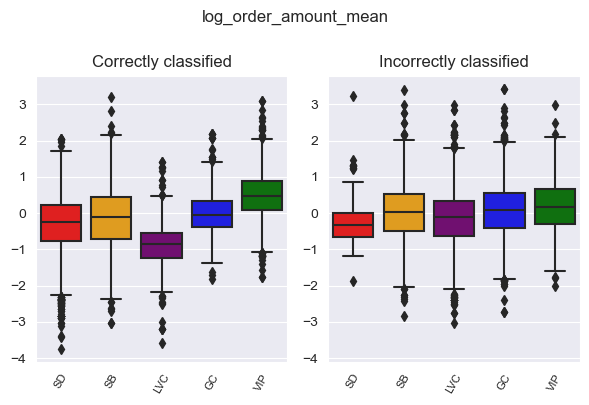

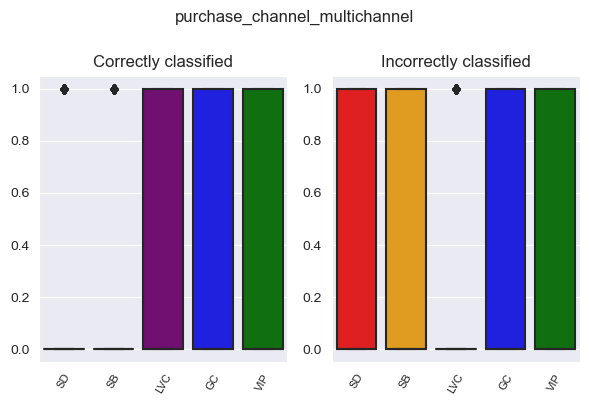

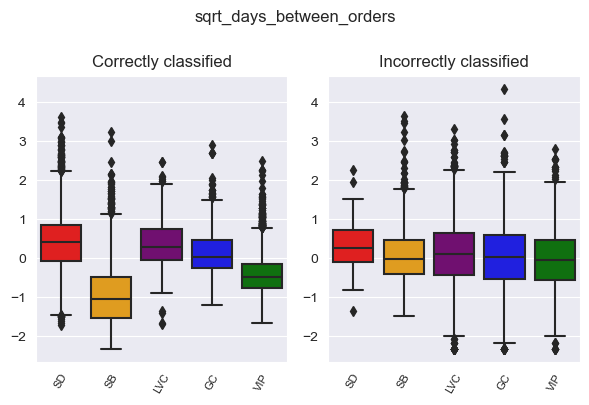

In [30]:
colors = ['red', 'orange', 'purple', 'blue', 'green']

for feature in top_features:
    fig = plt.figure(figsize=(6, 4))
    
    fig.suptitle(feature, fontsize=12, y=1.00)
    
    # Correctly classified
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(x='true_label', y=feature, data=df_correct, ax=ax1, palette=colors)
    plt.title('Correctly classified')
    ax1.set_xticklabels(class_names, rotation=60, fontsize=8)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    
    # Incorrectly classified
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    sns.boxplot(x='true_label', y=feature, data=df_incorrect, ax=ax2, palette=colors)
    plt.title('Incorrectly classified')
    ax2.set_xticklabels(class_names, rotation=60, fontsize=8)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

### Key Takeaways

1. **Days since last order**: Notable differences were observed for the 'Low Value Customers' class, with much higher values for correct predictions than for incorrect predictions. In general, days_since_last_order values are more closely distributed in correct predictions.

2. **Email rating**: The distribution of email rating is much more closely distributed in the case of correctly predicted samples, suggesting that the model might overvalue this feature, potentially leading to some incorrect predictions.

3. **Orders in the last month**: The 'Sleeping Beauty' and 'VIP' classes have a closer distribution for this feature in correctly classified samples, while incorrectly classified samples are full of outliers. This indicates that this feature might be causing trouble for the classifier.

**Recommendation**: It could be beneficial to reduce the number of features related to orders and group time ranges together (e.g., group order amount in the last month with order amounts in the last two and three months) to improve classifier performance.

# Conclusions

## Extreme Gradient Boosting (XGBoost) as our Classifier

We chose XGBoost Classifier as it achieves the best f1 weighted score while maintaining low overfitting.

Our model significantly outperforms the baseline of an accuracy of 0.36 (baseline choice is at the end of `02_Additional-EDA.ipynb`).

**Baseline classification report:**
```
                         precision    recall  f1-score   support

           Sleeping Dog       1.00      0.00      0.00      7803
        Sleeping Beauty       1.00      0.00      0.00      7823
    Low Value Customers       0.28      0.75      0.41      7800
         Good Customers       0.32      0.35      0.34      7740
                    VIP       0.56      0.70      0.62      7834

               accuracy                           0.36     39000
              macro avg       0.63      0.36      0.27     39000
           weighted avg       0.63      0.36      0.27     39000
```


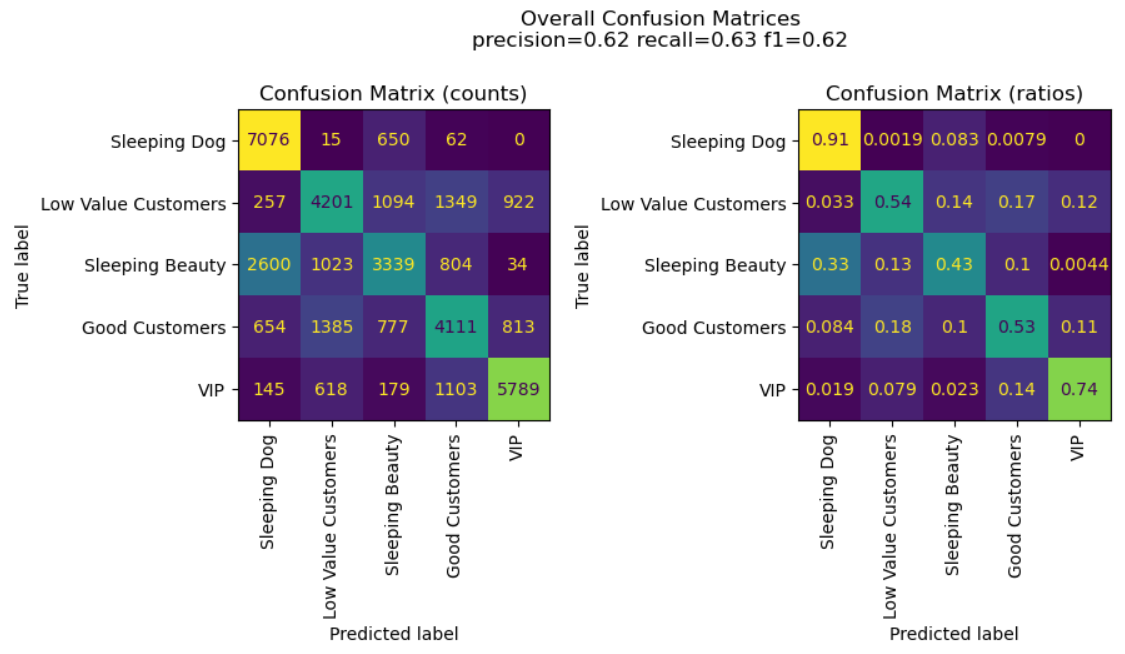

In [31]:
Image(filename='xgboost_overall.png', width=700)

In [32]:
def display_classification_reports(y_pred):
    """
    Takes predictions array as input and display classification report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    
    class_map = {
        'Sleeping Dog': 0,
        'Sleeping Beauty': 1,
        'Low Value Customers': 2,
        'Good Customers': 3,
        'VIP': 4
    }

    print("Overall classification report:")
    print(classification_report(y_test, y_pred, target_names=class_map.keys(), output_dict=False, zero_division=1))
 
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Extract class name from label
        class_name = label.split("_")[-1]

        # Find the corresponding value in class_map
        baseline_value = class_map[class_name]

        # Create y_baseline_subset with the same shape as y_pred_subset and fill with baseline_value
        y_baseline_subset = np.full_like(y_pred_subset, baseline_value)

        print(f"Classification report for {class_name} - Baseline:")
        print(classification_report(y_test_subset, y_baseline_subset, target_names=class_map.keys(), output_dict=False, zero_division=1))

        print(f"Classification report for {class_name} - Prediction:")
        print(classification_report(y_test_subset, y_pred_subset, target_names=class_map.keys(), output_dict=False, zero_division=1))

In [33]:
import xgboost as xgb

xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    max_depth=4,
    n_estimators=300,
    learning_rate=0.2,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
display_classification_reports(y_pred)

Overall classification report:
                     precision    recall  f1-score   support

       Sleeping Dog       0.66      0.91      0.76      7803
    Sleeping Beauty       0.58      0.54      0.56      7823
Low Value Customers       0.55      0.43      0.48      7800
     Good Customers       0.55      0.53      0.54      7740
                VIP       0.77      0.74      0.75      7834

           accuracy                           0.63     39000
          macro avg       0.62      0.63      0.62     39000
       weighted avg       0.62      0.63      0.62     39000

Classification report for Good Customers - Baseline:
                     precision    recall  f1-score   support

       Sleeping Dog       1.00      0.00      0.00      1011
    Sleeping Beauty       1.00      0.00      0.00      1743
Low Value Customers       1.00      0.00      0.00      1361
     Good Customers       0.32      1.00      0.49      2694
                VIP       1.00      0.00      0.00      15

The f1-scores have improved across all customer classes, indicating a more effective model in identifying and classifying customers:

- **Sleeping Dog / Sleeping Beauty:** Our model successfully predicts these classes with f1-scores of 0.76 and 0.55, respectively. This allows us to implement measures to counteract valuable customers falling into these categories.
- **Low Value Customers:** The f1-score increased from 0.41 to 0.48, a moderate improvement. However, our model's added value in this class is limited.
- **Good Customers:** The f1-score improved from 0.34 to 0.53, showcasing better classification capabilities.
- **VIP:** The f1-score rose from 0.62 to 0.75, reflecting a strong improvement in predicting VIP customers.

These results help us better tailor incentives and marketing strategies for each customer group, optimizing retention and satisfaction efforts.

### Classification VIP
Initial intention of our ML plan
> Predicting well VIP going to lower value classes as this could also be maybe prevented by offering strong incentives to those VIP.

Our model significantly outperforms the baseline in predicting VIPs moving to lower value classes and those remaining as VIPs. This information enables targeted incentives for VIP retention.

### Classification Good Customers
Initial intention of our ML plan
> Predicting Good Customers and VIP from existing classes as this can be directly used to argue for better incentives for those customer classes.

Our model shows improved accuracy, increasing from 0.32 to 0.56. F1-scores have improved for all classes compared to the baseline. Notably, the f1-scores for Good Customers and VIPs have increased from 0.49 and 0.00 in the baseline to 0.61 and 0.57 in the predictions, respectively. This demonstrates the model's effectiveness in identifying these customer classes, supporting the case for better incentives.

## Final Words

1. **Meta Classifiers:** We set up and tested a meta classifier, including stacking and voting classifiers. However, these approaches didn't yield significant improvements in the f1 weighted score for a similar overfitting threshold. Our understanding is that these classifiers could potentially provide marginal improvements across all classes if we were willing to accept higher overfitting.

2. **Additional Iteration:** In future iterations, we would consider aggregating the 'order_amount' feature, as we observed that the 'Sleeping Beauty' and 'VIP' classes have similar distributions for this feature in correctly classified samples, while incorrectly classified samples contain outliers. Moreover, the distribution of the email rating is much closer in correctly predicted samples, suggesting that the model might overvalue this feature and lead to incorrect predictions. Exploring aggregated order amount under larger time frames and trying a classifier without rating measures (email_domain_rating, email_behavior_rating) could be beneficial.

3. **A/B Testing:** Ideally, we would perform A/B testing in production, comparing a model with maximum overfitting (maximizing f1 weighted score) against the model presented in our conclusions. In cases where the future closely resembles the training data, we might achieve better performance with parameters that allow for overfitting. However, this would not be our primary approach, as overfitting can lead to poor generalization on new, unseen data.

### Acknowledgments

A big thank you to EPFL Extension School and all the excellent teachers for their hard work and dedication in creating such a valuable course. Your efforts are truly appreciated! 👍